# Fit Fors2 Spectra and Photometry with DSPS
Restricted to FORS2 galaxies with GALEX photometry

Implement this fit using this `fors2tostellarpopsynthesis` package

- Author Joseph Chevalier
- Afflilation : IJCLab/IN2P3/CNRS
- Organisation : LSST-DESC
- creation date : 2024-01-10
- last update : 2024-01-10 : Initial version

Most functions are inside the package. This notebook inherits largely from `Fors2ToStellarPopSynthesis/docs/notebooks/fitters/FitFors2ManySpecLoop.ipynb` in the `fors2tostellarpopsynthesis` package.

## Imports and general settings

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import re
import pickle 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
import collections
from collections import OrderedDict
import re
import matplotlib.gridspec as gridspec
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from tqdm import tqdm

import jax
import jax.numpy as jnp
from jax import vmap
import jaxopt
import optax
jax.config.update("jax_enable_x64", True)
from interpax import interp1d

In [2]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  16

In [3]:
kernel = kernels.RBF(0.5, (8000, 20000.0))
gpr = GaussianProcessRegressor(kernel=kernel ,random_state=0)

## Filters

In [4]:
from fors2tostellarpopsynthesis.filters import FilterInfo

In [5]:
FLAG_REMOVE_GALEX = False
FLAG_REMOVE_GALEX_FUV = True
FLAG_REMOVE_VISIBLE = False

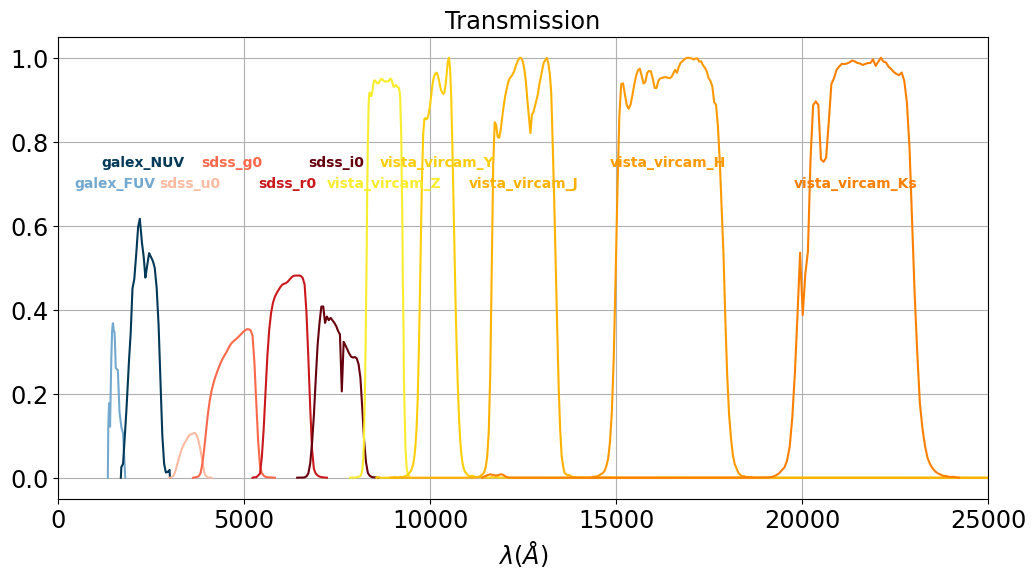

In [6]:
ps = FilterInfo()
ps.plot_transmissions()

## FORS2 and Starlight SPS extrapolation

In [7]:
from fors2tostellarpopsynthesis.fors2starlightio import Fors2DataAcess,\
                                                        SLDataAcess,\
                                                        convert_flux_torestframe,\
                                                        gpr

### Observed FORS2 data

['CLASS_STAR', 'DECJ2000', 'Delta_ZB', 'Delta_ZML', 'EXTINCTION_g', 'EXTINCTION_i', 'EXTINCTION_r', 'EXTINCTION_u', 'FLUXERR_GAAP_H', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_Ks', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_i', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_u', 'FLUX_GAAP_H', 'FLUX_GAAP_J', 'FLUX_GAAP_Ks', 'FLUX_GAAP_Y', 'FLUX_GAAP_Z', 'FLUX_GAAP_g', 'FLUX_GAAP_i', 'FLUX_GAAP_r', 'FLUX_GAAP_u', 'FLUX_RADIUS', 'ID', 'KIDS_TILE', 'MAGERR_GAAP_H', 'MAGERR_GAAP_J', 'MAGERR_GAAP_Ks', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_g', 'MAGERR_GAAP_i', 'MAGERR_GAAP_r', 'MAGERR_GAAP_u', 'MAG_GAAP_H', 'MAG_GAAP_J', 'MAG_GAAP_Ks', 'MAG_GAAP_Y', 'MAG_GAAP_Z', 'MAG_GAAP_g', 'MAG_GAAP_i', 'MAG_GAAP_r', 'MAG_GAAP_u', 'Nsp', 'RAJ2000', 'RT', 'RV', 'Rmag', 'Z_B', 'Z_ML', 'asep_galex', 'asep_kids', 'dec', 'dec_galex', 'eRV', 'fuv_flux', 'fuv_fluxerr', 'fuv_mag', 'fuv_magerr', 'lines', 'name', 'num', 'nuv_flux', 'nuv_fluxerr', 'nuv_mag', 'nuv_magerr', 'ra', 'ra_galex', 'redshift', 'z_se

/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


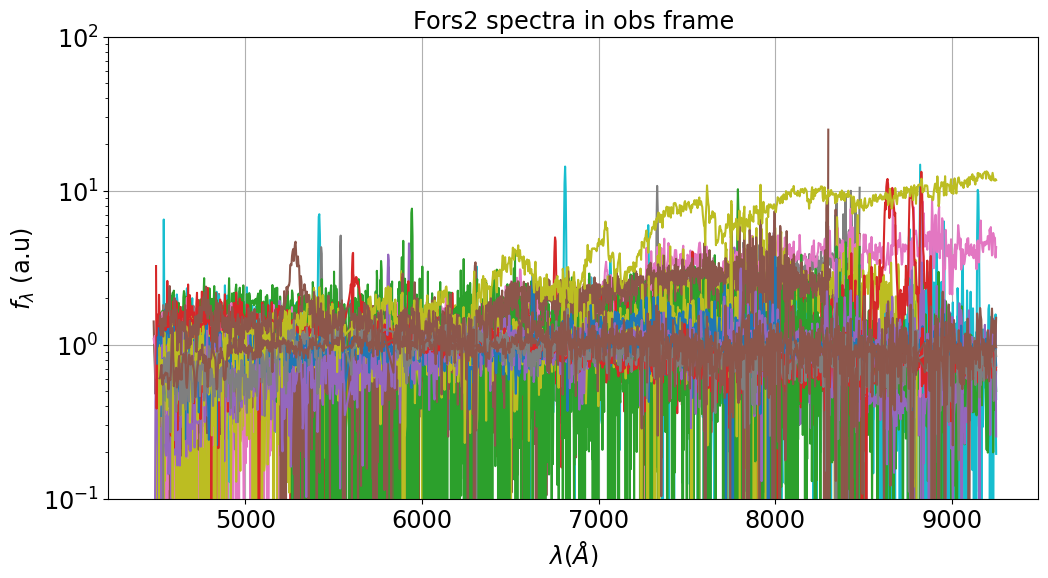

In [8]:
fors2 = Fors2DataAcess()
fors2_tags = fors2.get_list_of_groupkeys()
list_of_fors2_attributes = fors2.get_list_subgroup_keys()
print(list_of_fors2_attributes)
fors2.plot_allspectra()

### Extrapolated Starlight data

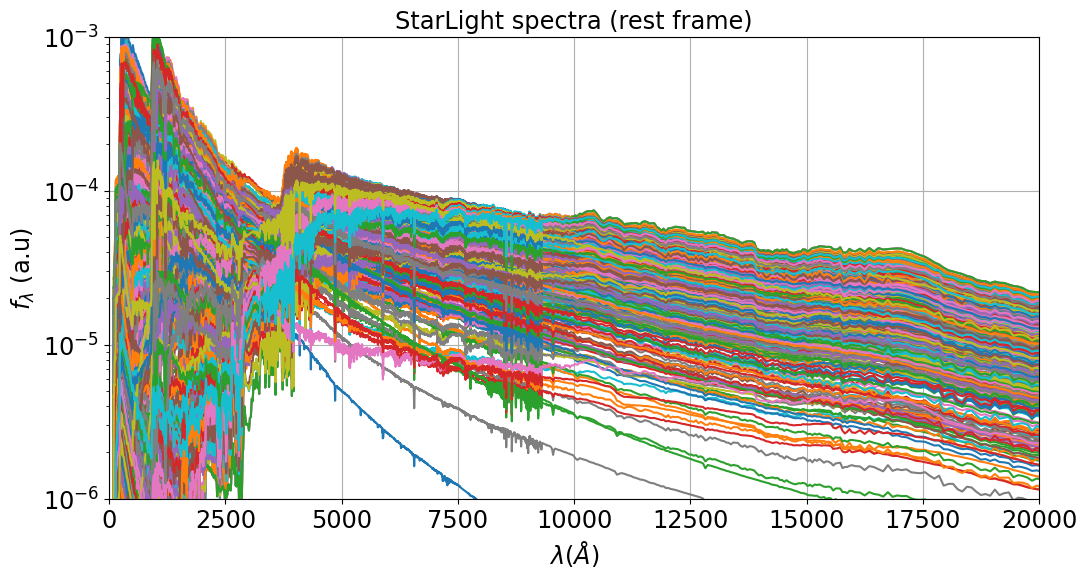

In [9]:
sl = SLDataAcess()
sl_tags = sl.get_list_of_groupkeys()
sl.plot_allspectra()

## Fitter with jaxopt

In [10]:
from fors2tostellarpopsynthesis.fitters.fitter_jaxopt import (lik_spec_ageDepMet_Q,\
                                                              lik_spec_from_mag_ageDepMet_Q,\
                                                              lik_normspec_from_mag_ageDepMet_Q,\
                                                              lik_mag_ageDepMet_Q,\
                                                              lik_ugri_ageDepMet_Q,\
                                                              lik_comb_ageDepMet_Q,\
                                                              get_infos_spec,\
                                                              get_infos_mag,\
                                                              get_infos_comb)

from fors2tostellarpopsynthesis.fitters.fitter_jaxopt import (SSP_DATA,\
                                                              mean_spectrum_ageDepMet_Q,\
                                                              mean_mags_ageDepMet_Q,\
                                                              mean_ugri_ageDepMet_Q,\
                                                              mean_sfr_ageDepMet_Q,\
                                                              ssp_spectrum_fromparam_ageDepMet_Q)

from fors2tostellarpopsynthesis.fitters.fitter_util import (plot_fit_ssp_photometry_ageDepMet_Q,\
                                                            plot_fit_ssp_spectrophotometry_ageDepMet_Q,\
                                                            plot_fit_ssp_spectrophotometry_sl_ageDepMet_Q,\
                                                            plot_fit_ssp_spectroscopy_ageDepMet_Q,\
                                                            plot_fit_ssp_ugri_ageDepMet_Q,\
                                                            plot_SFH_ageDepMet_Q,\
                                                            rescale_photometry_ageDepMet_Q,\
                                                            rescale_spectroscopy_ageDepMet_Q,\
                                                            rescale_starlight_inrangefors2)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
['galex', 'galex', 'sdss', 'sdss', 'sdss', 'sdss', 'vircam', 'vircam', 'vircam', 'vircam', 'vircam']
['galex_FUV', 'galex_NUV', 'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'vista_vircam_Z', 'vista_vircam_Y', 'vista_vircam_J', 'vista_vircam_H', 'vista_vircam_Ks']


## Parameters to fit

In [11]:
from fors2tostellarpopsynthesis.parameters import (SSPParametersFit_AgeDepMet_Q,\
                                                   paramslist_to_dict)

## Select applicable spectra

In [12]:
filtered_tags = []
for idx, tag in enumerate(fors2_tags):
    fors2_attr = fors2.getattribdata_fromgroup(tag)

    bool_viz = FLAG_REMOVE_VISIBLE or (not(FLAG_REMOVE_VISIBLE)\
                                       and np.isfinite(fors2_attr['MAG_GAAP_u'])\
                                       and np.isfinite(fors2_attr['MAG_GAAP_g'])\
                                       and np.isfinite(fors2_attr['MAG_GAAP_r'])\
                                       and np.isfinite(fors2_attr['MAG_GAAP_i'])\
                                       and np.isfinite(fors2_attr['MAGERR_GAAP_u'])\
                                       and np.isfinite(fors2_attr['MAGERR_GAAP_g'])\
                                       and np.isfinite(fors2_attr['MAGERR_GAAP_r'])\
                                       and np.isfinite(fors2_attr['MAGERR_GAAP_i']))

    bool_fuv = (FLAG_REMOVE_GALEX or FLAG_REMOVE_GALEX_FUV) or (not(FLAG_REMOVE_GALEX or FLAG_REMOVE_GALEX_FUV)\
                                                                and np.isfinite(fors2_attr['fuv_mag'])\
                                                                and np.isfinite(fors2_attr['fuv_magerr']))

    bool_nuv = FLAG_REMOVE_GALEX or (not(FLAG_REMOVE_GALEX)\
                                     and np.isfinite(fors2_attr['nuv_mag'])\
                                     and np.isfinite(fors2_attr['nuv_magerr']))

    if bool_viz and bool_fuv and bool_nuv :
        filtered_tags.append(tag)
len(filtered_tags)

408

In [13]:
#random_tags = np.random.choice(selected_tags, size=5, replace=False)
low_bound, high_bound = 1, 5
low_bound -= 1
high_bound = min(high_bound, len(filtered_tags))
low_bound = min(low_bound, high_bound-1)

selected_tags = filtered_tags[62:63]
start_tag, end_tag = selected_tags[0], selected_tags[-1]

Photometry in UV is not consistant with the extrapolated spectrum. Further checks are needed.
A good start would be to actually triple-check the correspondance between FORS2 spectra and sources of photometry.

## Attempt with fewer parameters and age-dependant, fixed-bounds metallicity

In [14]:
dict_fors2_for_fit = {}
for tag in tqdm(selected_tags):
    dict_tag = {}
    # extract most basic info
    selected_spectrum_number = int(re.findall("^SPEC(.*)", tag)[0])
    fors2_attr = fors2.getattribdata_fromgroup(tag)
    z_obs = fors2_attr['redshift']
    title_spec = f"{tag} z = {z_obs:.2f}"

    dict_tag["spec ID"] = selected_spectrum_number
    dict_tag["redshift"] = z_obs
    dict_tag["title"] = title_spec

    # retrieve magnitude data
    data_mags, data_magserr = fors2.get_photmagnitudes(tag)
    ugri_mags_c, ugri_magserr_c = fors2.get_ugrimagnitudes_corrected(tag) # KiDS ugri magnitudes
                                                                        # corrected for dust extinction

    # get the Fors2 spectrum
    spec_obs = fors2.getspectrumcleanedemissionlines_fromgroup(tag)
    Xs = spec_obs['wl']
    Ys = spec_obs['fnu']
    EYs = spec_obs['bg']
    EYs_med = spec_obs['bg_med']

    # convert to restframe
    Xspec_data, Yspec_data = convert_flux_torestframe(Xs, Ys, z_obs)
    EYspec_data = EYs #* (1+z_obs)
    EYspec_data_med = EYs_med #* (1+z_obs)

    dict_tag["wavelengths"] = Xspec_data
    dict_tag["fnu"] = Yspec_data
    dict_tag["fnu_err"] = EYspec_data

    # smooth the error over the spectrum
    #fit_res = gpr.fit(Xspec_data[:, None], EYspec_data)
    #EYspec_data_sm = gpr.predict(Xspec_data[:, None], return_std=False)

    # need to increase error to decrease chi2 error
    #EYspec_data_sm *= 2

    # Choose filters with mags without Nan
    NoNaN_mags = np.intersect1d(np.argwhere(~np.isnan(data_mags)).flatten(),\
                                np.argwhere(~np.isnan(data_magserr)).flatten())

    # selected indexes for filters
    index_selected_filters = NoNaN_mags

    if FLAG_REMOVE_GALEX:
        galex_indexes = np.array([0,1])
        index_selected_filters = np.setdiff1d(NoNaN_mags, galex_indexes)
    elif FLAG_REMOVE_GALEX_FUV:
        galex_indexes = np.array([0])
        index_selected_filters = np.setdiff1d(NoNaN_mags, galex_indexes)    

    if FLAG_REMOVE_VISIBLE:
        visible_indexes = np.array([2, 3, 4, 5, 6, 7])
        index_selected_filters = np.setdiff1d(NoNaN_mags, visible_indexes)

    # Select filters
    XF = ps.get_2lists()
    NF = len(XF[0])
    list_wls_f_sel = []
    list_trans_f_sel = []
    list_name_f_sel = []
    list_wlmean_f_sel = []

    for index in index_selected_filters:
        list_wls_f_sel.append(XF[0][index])
        list_trans_f_sel.append(XF[1][index])
        the_filt = ps.filters_transmissionlist[index]
        the_wlmean = the_filt.wave_mean
        list_wlmean_f_sel.append(the_wlmean)
        list_name_f_sel.append(ps.filters_namelist[index])

    list_wlmean_f_sel = jnp.array(list_wlmean_f_sel)
    Xf_sel = (list_wls_f_sel, list_trans_f_sel)

    NoNan_ugri = np.intersect1d(NoNaN_mags, np.array([2, 3, 4, 5]))
    list_wls_ugri = []
    list_trans_ugri = []
    list_name_ugri = []
    list_wlmean_ugri = []

    for index in NoNan_ugri:
        list_wls_ugri.append(XF[0][index])
        list_trans_ugri.append(XF[1][index])
        the_filt = ps.filters_transmissionlist[index]
        the_wlmean = the_filt.wave_mean
        list_wlmean_ugri.append(the_wlmean)
        list_name_ugri.append(ps.filters_namelist[index])

    list_wlmean_ugri = jnp.array(list_wlmean_ugri)
    Xf_ugri = (list_wls_ugri, list_trans_ugri)
    print(NoNan_ugri, list_name_ugri)

    # get the magnitudes and magnitude errors
    data_selected_mags =  jnp.array(data_mags[index_selected_filters])
    data_selected_magserr = jnp.array(data_magserr[index_selected_filters])
    data_selected_ugri_corr =  jnp.array(ugri_mags_c)
    data_selected_ugri_correrr = jnp.array(ugri_magserr_c)

    dict_tag["filters"] = Xf_sel
    dict_tag["wl_mean_filters"] = list_wlmean_f_sel
    dict_tag["mags"] = data_selected_mags
    dict_tag["mags_err"] = data_selected_magserr
    dict_tag["ugri_filters"] = Xf_ugri
    dict_tag["wl_mean_ugri"] = list_wlmean_ugri
    dict_tag["ugri_corr"] = data_selected_ugri_corr
    dict_tag["ugri_corr_err"] = data_selected_ugri_correrr

    dict_fors2_for_fit[tag] = dict_tag

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]/home/joseph/anaconda3/envs/conda_photoZ/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 6000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

[2 3 4 5] ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0']


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

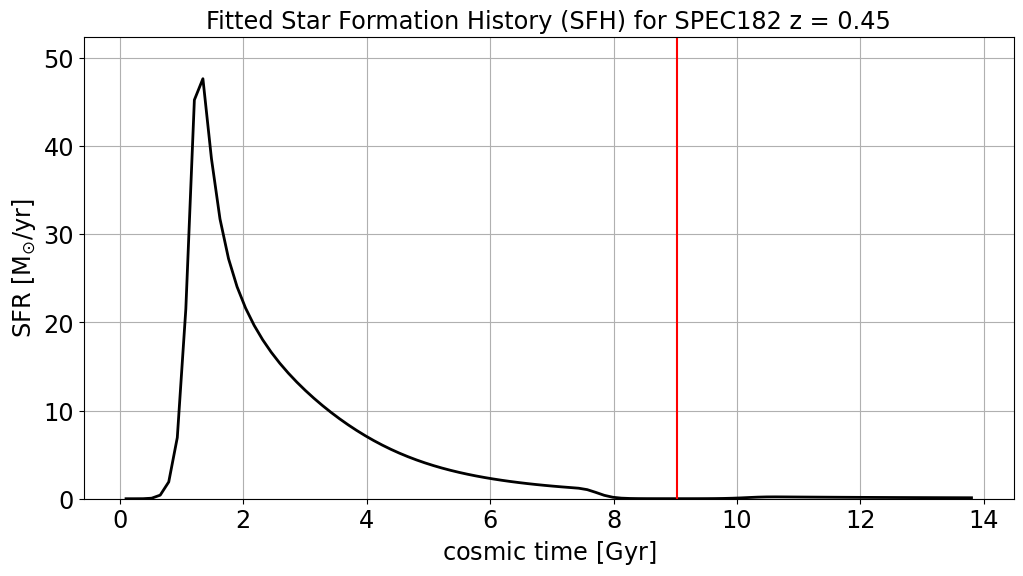

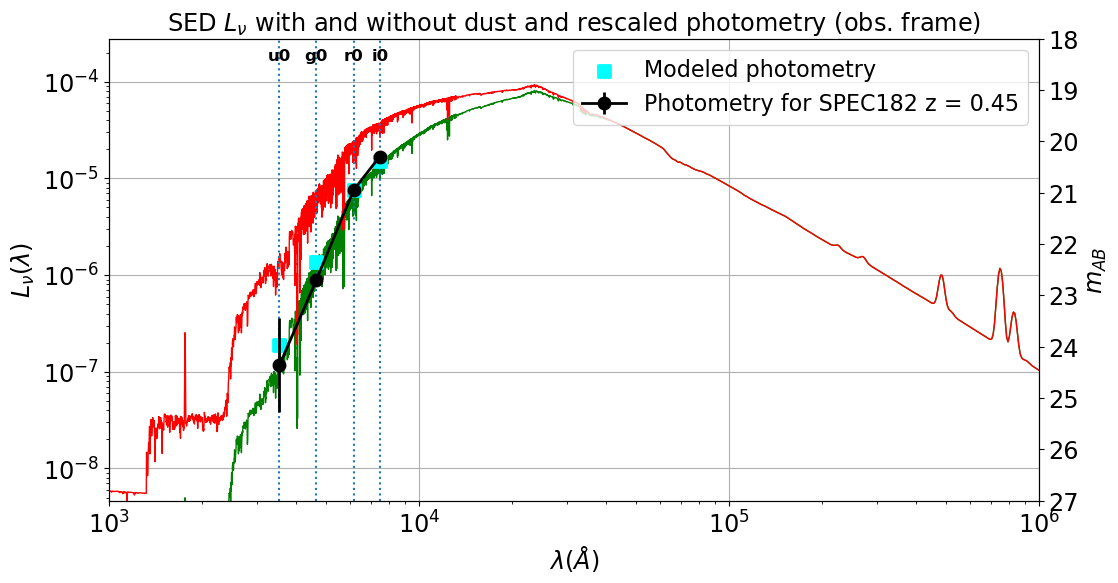

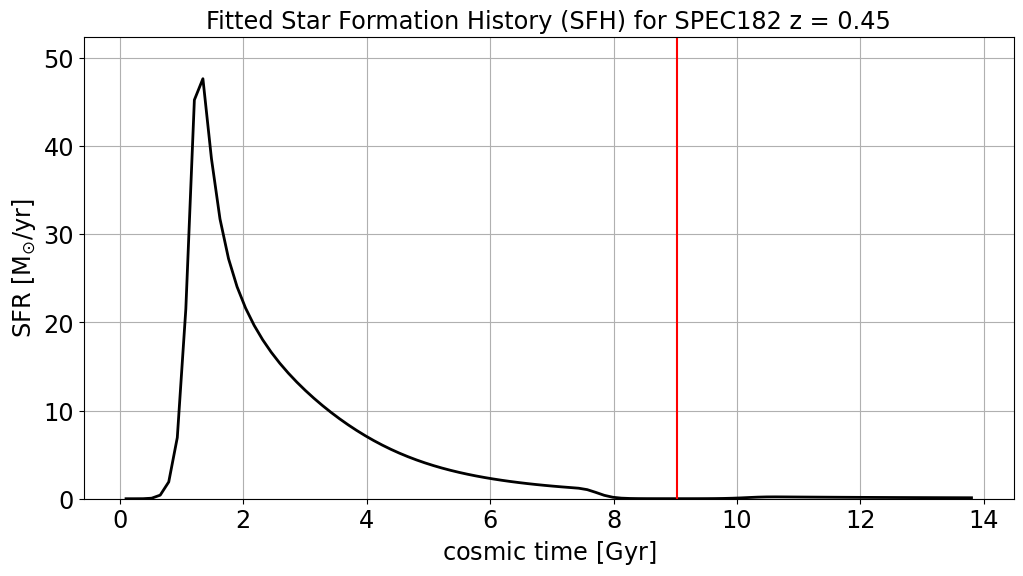

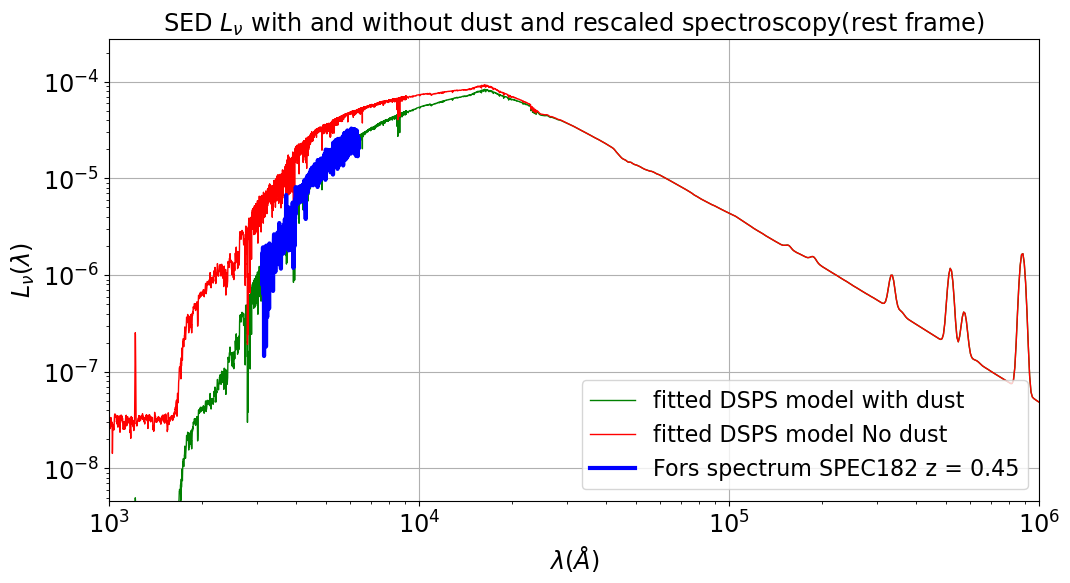

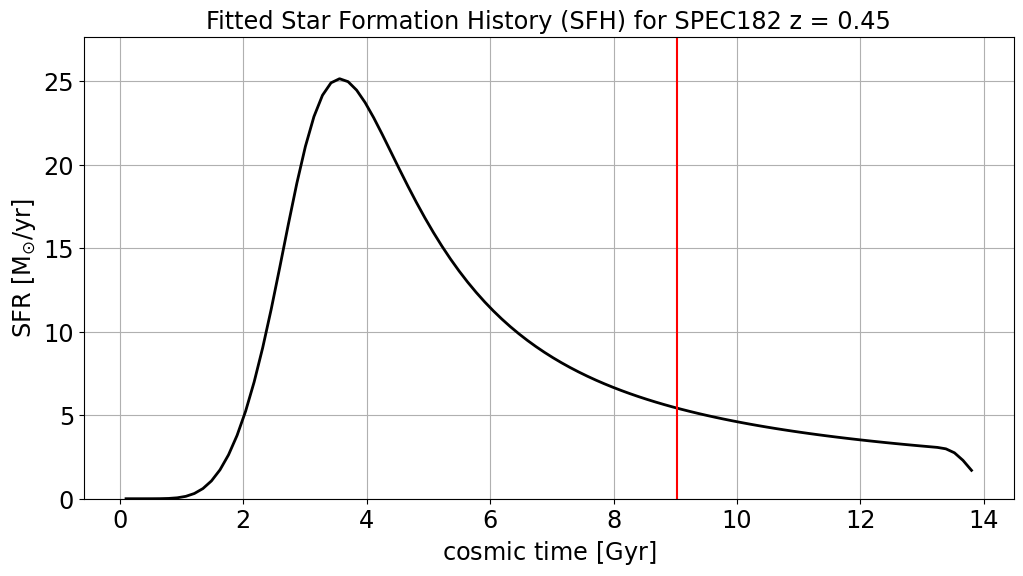

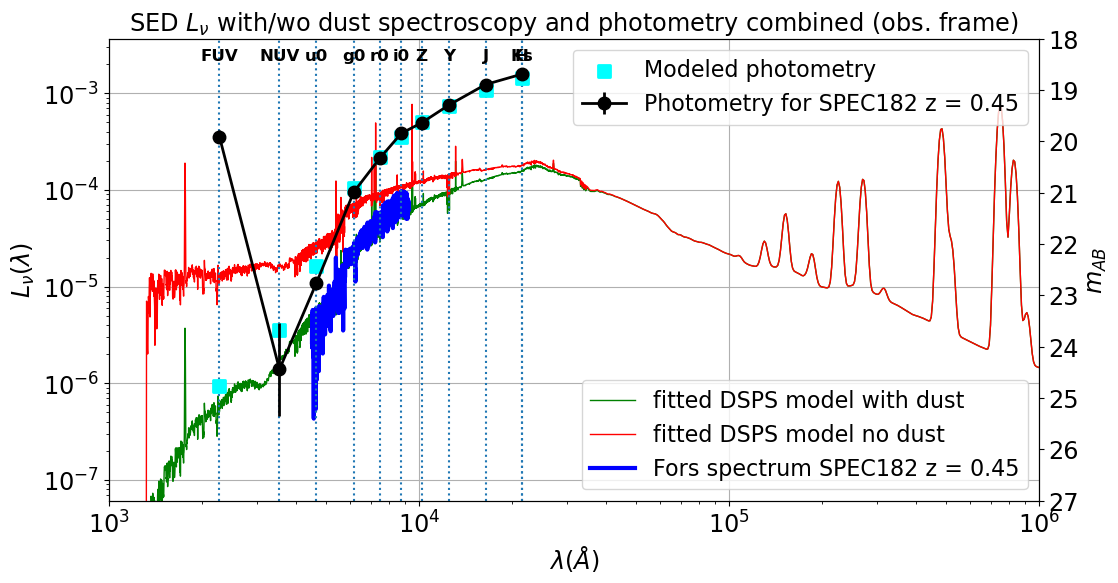

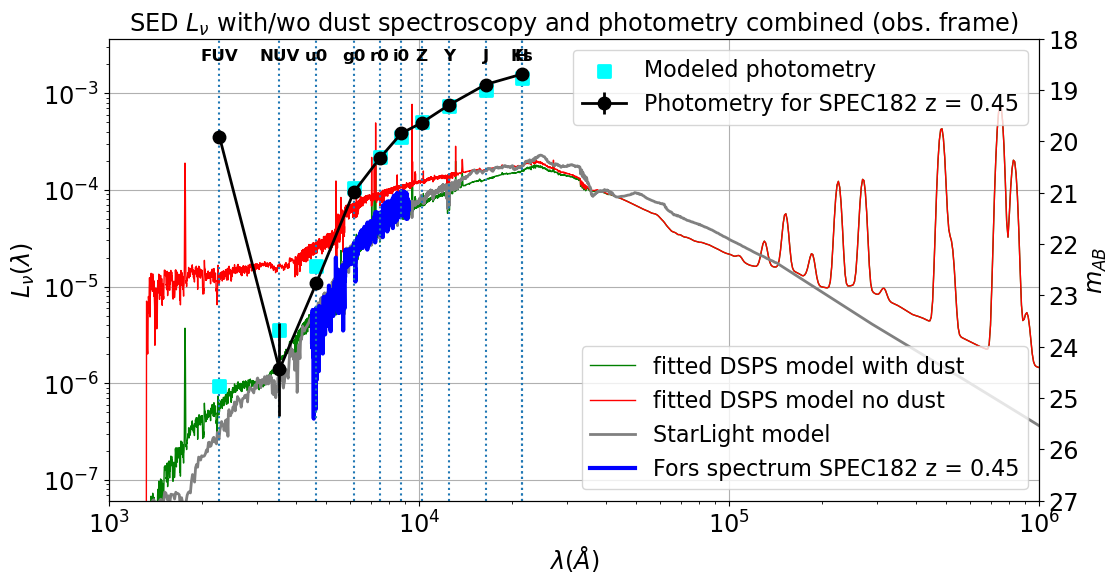

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:11<00:00, 71.15s/it]


In [15]:
# parameters for fit
p = SSPParametersFit_AgeDepMet_Q()
init_params = p.INIT_PARAMS
params_min = p.PARAMS_MIN
params_max = p.PARAMS_MAX
lbfgsb_ugri = jaxopt.ScipyBoundedMinimize(fun = lik_ugri_ageDepMet_Q, method = "L-BFGS-B", maxiter=5000)
lbfgsb_mag = jaxopt.ScipyBoundedMinimize(fun = lik_mag_ageDepMet_Q, method = "L-BFGS-B", maxiter=5000)
lbfgsb_spec = jaxopt.ScipyBoundedMinimize(fun = lik_normspec_from_mag_ageDepMet_Q, method = "L-BFGS-B", maxiter=5000)
lbfgsb_comb = jaxopt.ScipyBoundedMinimize(fun = lik_comb_ageDepMet_Q, method = "L-BFGS-B", maxiter=5000)

# fit loop
for tag in tqdm(dict_fors2_for_fit):
    data_dict = dict_fors2_for_fit[tag]

    # fit with magnitudes only
    res_m = lbfgsb_ugri.run(init_params,\
                            bounds=(params_min, params_max),\
                            xf = data_dict["ugri_filters"],\
                            mags_measured = data_dict["ugri_corr"],\
                            sigma_mag_obs = data_dict["ugri_corr_err"],\
                            z_obs = data_dict["redshift"])
    '''
    params_m, fun_min_m, jacob_min_m, inv_hessian_min_m = get_infos_mag(res_m,\
                                                                        lik_mag_ageDepMet_Q,\
                                                                        xf = data_dict["filters"],\
                                                                        mgs = data_dict["mags"],\
                                                                        mgse = data_dict["mags_err"],\
                                                                        z_obs=data_dict["redshift"])
    '''
    #print("params:",params_m,"\nfun@min:",fun_min_m,"\njacob@min:",jacob_min_m)

    # Convert fitted parameters into a dictionnary
    params_m = res_m.params
    dict_params_m = paramslist_to_dict(params_m, p.PARAM_NAMES_FLAT)

    '''
    # rescale photometry datapoints
    xphot_rest, yphot_rest, eyphot_rest, factor\
    = rescale_photometry_ageDepMet_Q(dict_params_m,\
                                     dict_tag["wl_mean_filters"],\
                                     data_dict["mags"],\
                                     data_dict["mags_err"],\
                                     data_dict["redshift"])

    #rescale Fors2 spectroscopy
    Xspec_data_rest, Yspec_data_rest, EYspec_data_rest, factor\
    = rescale_spectroscopy_ageDepMet_Q(dict_params_m,\
                                       data_dict["wavelengths"],\
                                       data_dict["fnu"],\
                                       data_dict["fnu_err"],\
                                       data_dict["redshift"])
    '''
    # plot SFR
    plot_SFH_ageDepMet_Q(dict_params_m, data_dict["redshift"], subtit = data_dict["title"], ax=None)

    # plot fit for photometry only
    plot_fit_ssp_ugri_ageDepMet_Q(dict_params_m,\
                                  data_dict["ugri_filters"],\
                                  data_dict["wl_mean_ugri"],\
                                  data_dict["ugri_corr"],\
                                  data_dict["ugri_corr_err"],\
                                  data_dict["redshift"],\
                                  data_dict["title"])

    # fit spectroscopy
    p_to_fit = jnp.array([_par for _par in params_m[-3:]])
    p_fixed = jnp.array([_par for _par in params_m[:-3]])
    res_s = lbfgsb_spec.run(p_to_fit,\
                            bounds = (params_min[-3:], params_max[-3:]),\
                            p_fix = p_fixed,\
                            wls = data_dict["wavelengths"],\
                            F = data_dict["fnu"],\
                            sigma_obs = data_dict["fnu_err"],\
                            z_obs = data_dict["redshift"])
    '''
    params_s, fun_min_s, jacob_min_s, inv_hessian_min_s = get_infos_spec(res_s,\
                                                                         lik_spec_ageDepMet_Q,\
                                                                         wls = data_dict["wavelengths"],\
                                                                         F = data_dict["fnu"],\
                                                                         eF = data_dict["fnu_err"],\
                                                                         z_obs = data_dict["redshift"])
    '''
    #print("params:",params_s,"\nfun@min:",fun_min_s,"\njacob@min:",jacob_min_s)

    # Convert fitted parameters with spectroscopy into a dictionnary
    params_s = res_s.params
    dict_params_s = paramslist_to_dict(jnp.concatenate((params_m[:-3], params_s)), p.PARAM_NAMES_FLAT)

    # plot SFR
    plot_SFH_ageDepMet_Q(dict_params_s, data_dict["redshift"], subtit = data_dict["title"], ax=None)

    # plot fit for spectroscopy only
    Xspec_plot, Yspec_plot, EYspec_plot, factor\
    = rescale_spectroscopy_ageDepMet_Q(dict_params_s,\
                                       data_dict["wavelengths"],\
                                       data_dict["fnu"],\
                                       data_dict["fnu_err"],\
                                       data_dict["redshift"])
    plot_fit_ssp_spectroscopy_ageDepMet_Q(dict_params_s,\
                                               Xspec_plot,\
                                               Yspec_plot,\
                                               EYspec_plot,\
                                               data_dict["redshift"],\
                                               subtit = data_dict["title"])
    
    # Second fit on photometry, taking into account the effect of dust as fitted previously
    p_to_fit = jnp.array([_par for _par in params_m[:-3]])
    p_fixed = jnp.array([_par for _par in params_s])
    res_mm = lbfgsb_mag.run(p_to_fit,\
                            bounds = (params_min[:-3], params_max[:-3]),\
                            p_fix = p_fixed,\
                            xf = data_dict["filters"],\
                            mags_measured = data_dict["mags"],\
                            sigma_mag_obs = data_dict["mags_err"],\
                            z_obs = data_dict["redshift"])
    params_mm = res_mm.params
    dict_params_mm = paramslist_to_dict(jnp.concatenate((params_mm, params_s)), p.PARAM_NAMES_FLAT)

    # rescale photometry datapoints
    '''
    xphot_rest, yphot_rest, eyphot_rest, factor\
    = rescale_photometry_ageDepMet_Q(dict_params_s,\
                                     data_dict["wl_mean_filters"],\
                                     data_dict["mags"],\
                                     data_dict["mags_err"],\
                                     data_dict["redshift"])
    '''
    xphot_rest = data_dict["wl_mean_filters"]
    yphot_rest, eyphot_rest = data_dict["mags"], data_dict["mags_err"]

    #rescale Fors2 spectroscopy
    Xspec_data_rest, Yspec_data_rest, EYspec_data_rest, factor\
    = rescale_spectroscopy_ageDepMet_Q(dict_params_mm,\
                                       data_dict["wavelengths"],\
                                       data_dict["fnu"],\
                                       data_dict["fnu_err"],\
                                       data_dict["redshift"])

    # plot SFR
    plot_SFH_ageDepMet_Q(dict_params_mm, data_dict["redshift"], subtit = data_dict["title"], ax=None)

    # plot fit for spectroscopy only
    plot_fit_ssp_spectrophotometry_ageDepMet_Q(dict_params_mm,\
                                               Xspec_data_rest,\
                                               Yspec_data_rest,\
                                               EYspec_data_rest,\
                                               data_dict["filters"],\
                                               data_dict["wl_mean_filters"],\
                                               data_dict["mags"],\
                                               data_dict["mags_err"],\
                                               data_dict["redshift"],\
                                               subtit = data_dict["title"])

    #save to dictionary
    dict_out = OrderedDict()
    dict_out["fors2name"] = tag
    dict_out["zobs"] = data_dict["redshift"]
    #Ns = len(Yspec_data_rest)
    #dict_out["Ns"] = Ns
    #dict_out["funcmin_s"] = fun_min_s

    # convert into a dictionnary
    #dict_out.update(dict_params_s)
    #dict_out.update(dict_params_m)
    dict_out.update(dict_params_mm)

    '''
    # combining spectro and photometry
    Xc = [Xspec_data_rest, Xf_sel]
    Yc = [Yspec_data_rest, data_selected_mags]
    EYc = [EYspec_data_rest, data_selected_magserr]
    weight_spec = 0.5
    Ns = len(Yspec_data_rest)
    Nm = len(data_selected_mags)
    Nc = Ns+Nm

    # do the combined fit
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun = lik_comb_ageDepMet_Q, method = "L-BFGS-B")
    res_c = lbfgsb.run(init_params,\
                       bounds = (params_min, params_max),\
                       xc = Xc,\
                       datac = Yc,\
                       sigmac = EYc,\
                       z_obs = z_obs,\
                       weight = weight_spec)
    params_c, fun_min_c, jacob_min_c, inv_hessian_min_c = get_infos_comb(res_c,\
                                                                         lik_comb_ageDepMet_Q,\
                                                                         xc = Xc,\
                                                                         datac = Yc,\
                                                                         sigmac = EYc,\
                                                                         z_obs = z_obs,\
                                                                         weight = weight_spec)
    params_cm, fun_min_cm, jacob_min_cm, inv_hessian_min_cm  = get_infos_mag(res_c,\
                                                                             lik_mag_ageDepMet_Q,\
                                                                             xf = Xf_sel,\
                                                                             mgs = data_selected_mags,\
                                                                             mgse = data_selected_magserr,\
                                                                             z_obs = z_obs)
    params_cs, fun_min_cs, jacob_min_cs, inv_hessian_min_cs = get_infos_spec(res_c,\
                                                                             lik_spec_ageDepMet_Q,\
                                                                             wls = Xspec_data_rest,\
                                                                             F = Yspec_data_rest,\
                                                                             eF = EYspec_data_rest,\
                                                                             z_obs = z_obs)
    print("params_c:", params_c, "\nfun@min:", fun_min_c, "\njacob@min:", jacob_min_c) #,"\n invH@min:",inv_hessian_min_c)
    print("params_cm:", params_cm, "\nfun@min:", fun_min_cm, "\njacob@min:", jacob_min_cm)
    print("params_cs:", params_cs, "\nfun@min:", fun_min_cs, "\njacob@min:", jacob_min_cs)

    #save to dictionary
    dict_out = OrderedDict()
    dict_out["fors2name"] = tag
    dict_out["zobs"] = z_obs
    dict_out["Nc"] = Nc
    dict_out["Ns"] = Ns
    dict_out["Nm"] = Nm
    dict_out["funcmin_c"] = fun_min_c
    dict_out["funcmin_m"] = fun_min_cm
    dict_out["funcmin_s"] = fun_min_cs

    # convert into a dictionnary
    dict_params_c = paramslist_to_dict(params_c, p.PARAM_NAMES_FLAT) 
    dict_out.update(dict_params_c)

    # plot the combined fit
    plot_fit_ssp_spectrophotometry_ageDepMet_Q(dict_params_c,\
    Xspec_data_rest,\
                                   Yspec_data_rest,\
                                   EYspec_data_rest,\
                                                data_dict["filters"],\
                                   xphot_rest,\
                                   yphot_rest,\
                                   eyphot_rest,\
                                   z_obs = z_obs,\
                                   subtit = title_spec )
    '''
    
    #load starlight spectrum
    dict_sl = sl.getspectrum_fromgroup(tag)

    # rescale starlight spectrum
    w_sl, fnu_sl, _ = rescale_starlight_inrangefors2(dict_sl["wl"],\
                                                     dict_sl["fnu"],\
                                                     Xspec_data_rest,\
                                                     Yspec_data_rest)

    # plot starlight
    plot_fit_ssp_spectrophotometry_sl_ageDepMet_Q(dict_params_mm,\
                                                  Xspec_data_rest,\
                                                  Yspec_data_rest,\
                                                  EYspec_data_rest,\
                                                  data_dict["filters"],\
                                                  xphot_rest,\
                                                  yphot_rest,\
                                                  eyphot_rest,\
                                                  w_sl,\
                                                  fnu_sl,\
                                                  data_dict["redshift"],\
                                                  data_dict["title"])

    #save parameters
    '''
    filename_params = f"DSPS_pickles/fitparams_{tag}_galex_ageDepMet_Q_specOnly.pickle"
    with open(filename_params, 'wb') as f:
        #print(dict_out)
        pickle.dump(dict_out, f)
    '''

## Metallicity

In [16]:
from dsps.cosmology import DEFAULT_COSMOLOGY, age_at_z

# metallicity
gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

# need age of universe when the light was emitted
t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

In [17]:
tau_arr = t_obs-jnp.power(10, SSP_DATA.ssp_lg_age_gyr)
tau_arr

Array([  9.02787257,   9.02786037,   9.02784668,   9.02783131,
         9.02781408,   9.02779474,   9.02777304,   9.0277487 ,
         9.02772138,   9.02769073,   9.02765634,   9.02761775,
         9.02757446,   9.02752588,   9.02747138,   9.02741023,
         9.02734161,   9.02726462,   9.02717824,   9.02708132,
         9.02697257,   9.02685055,   9.02671364,   9.02656003,
         9.02638767,   9.02619429,   9.02597731,   9.02573385,
         9.02546068,   9.02515419,   9.02481029,   9.02442443,
         9.0239915 ,   9.02350573,   9.0229607 ,   9.02234915,
         9.02166299,   9.02089311,   9.02002929,   9.01906006,
         9.01797257,   9.01675238,   9.01538331,   9.01384719,
         9.01212364,   9.01018977,   9.00801994,   9.00558536,
         9.0028537 ,   8.99978874,   8.99634979,   8.99249123,
         8.98816185,   8.98330421,   8.97785384,   8.97173844,
         8.96487683,   8.95717799,   8.94853974,   8.93884747,
         8.92797257,   8.91577072,   8.90208003,   8.88

In [18]:
from dsps.utils import triweight_gaussian

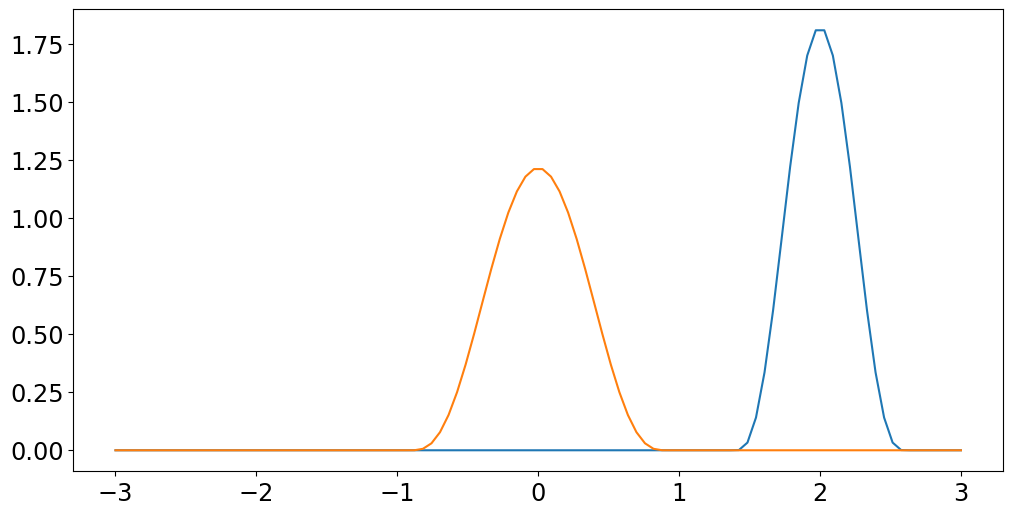

In [19]:
metals = jnp.linspace(-3, 3, 100)
plt.plot(metals, triweight_gaussian(metals, 2., 0.2))
plt.plot(metals, triweight_gaussian(metals, 0., 0.3))

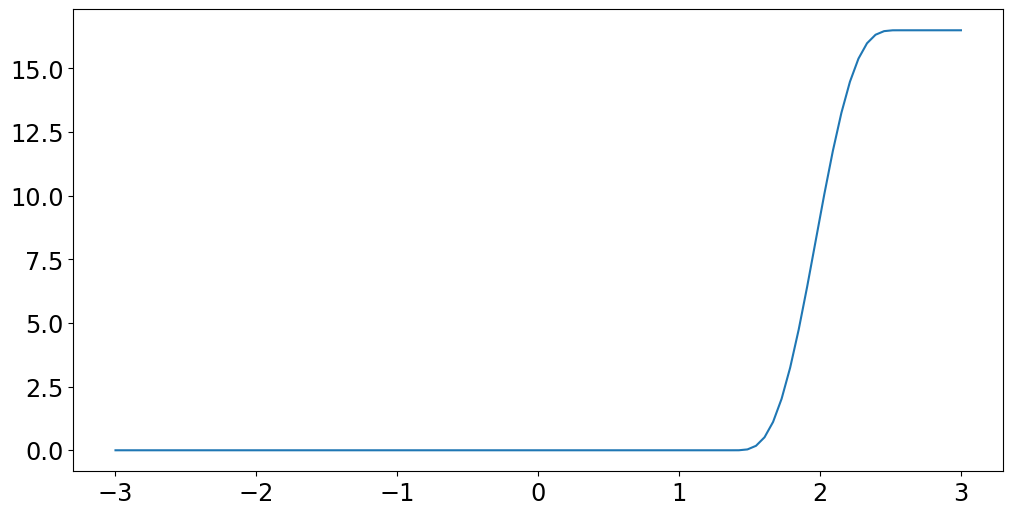

In [20]:
mdf = triweight_gaussian(metals, 2., 0.2)
cum_twg = jnp.cumsum(mdf)
plt.plot(metals, cum_twg)

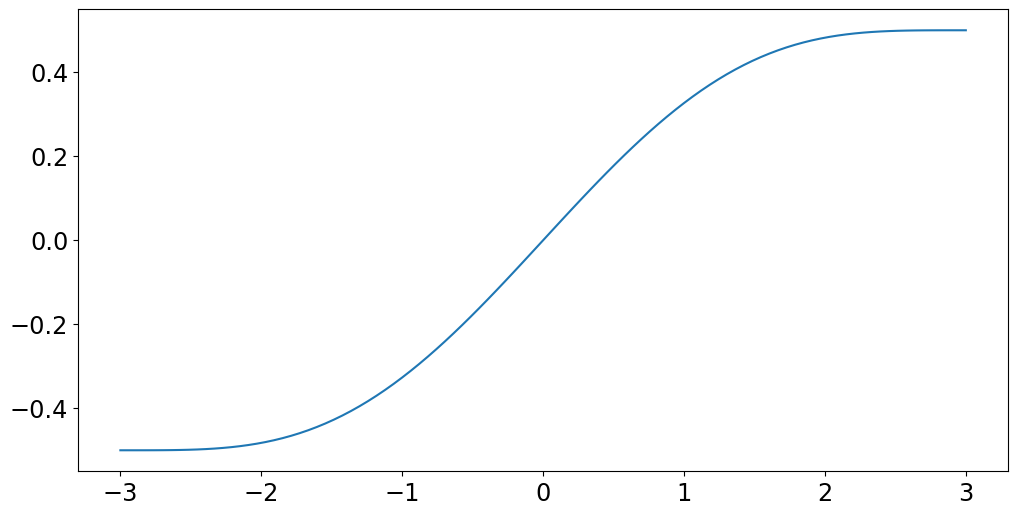

In [21]:
zzz = jnp.linspace(-3, 3, 100)
plt.plot(zzz, zzz*35/96 - zzz**3 * 35/864 + zzz**5 * 7/2592 - zzz**7 * 5/69984)

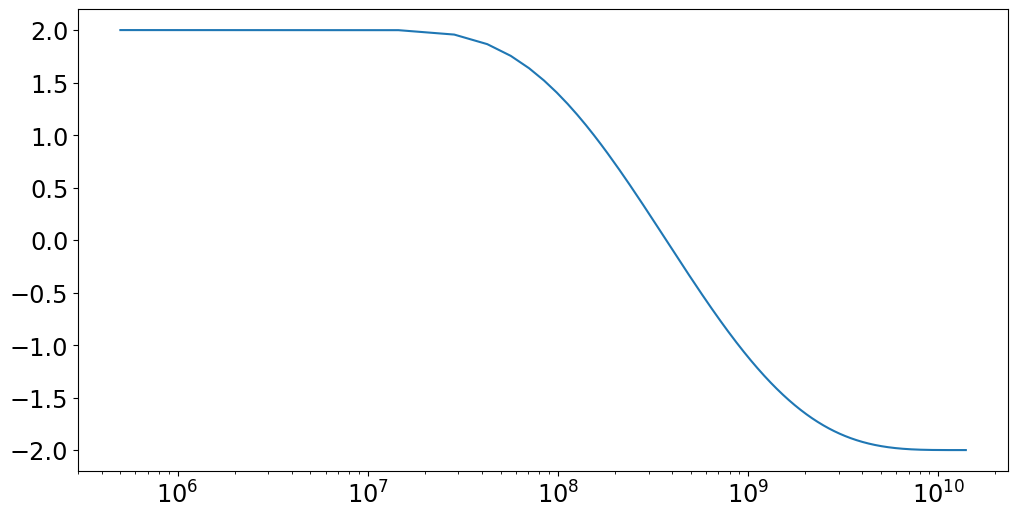

In [22]:
mu_old, mu_young = -2, 2

tau_yrs = tau_arr * 10**9
t_avg = jnp.average(tau_arr)
t_sig = jnp.abs(jnp.max(tau_arr)-jnp.min(tau_arr))/6

def mu_tau_triweight_cumulative(age, mu_old, mu_young):
    mu_mid = 0.5*(jnp.log10(13.8) + jnp.log10(0.01))
    sigma_mu = jnp.abs(jnp.log10(13.8)-jnp.log10(0.01))/6
    z = (jnp.log10(age)-mu_mid)/sigma_mu
    p_z = (mu_young+mu_old)/2 - (mu_young-mu_old)*(z*35/96 - z**3 * 35/864 + z**5 * 7/2592 - z**7 * 5/69984)
    p_z = jnp.where((z < -3), mu_young, p_z)
    p_z = jnp.where((z > 3), mu_old, p_z)
    return p_z

def mu_tau_triweight(age, mu_old, mu_young):
    mu_mid = 0.5*(jnp.log10(13.8) + jnp.log10(0.001))
    sigma_mu = jnp.abs(jnp.log10(13.8)-jnp.log10(0.001))/6
    z = (jnp.log10(age)-mu_mid)/sigma_mu
    _msk = (z < -3) | (z > 3)
    p_z = 35 * jnp.power(1 - jnp.power(z/3, 2), 3) / 96
    return jnp.where(_msk, 0, p_z)

tau_arr = jnp.linspace(0.0005, 14, 1000)

t_kernel = mu_tau_triweight_cumulative(tau_arr, mu_old, mu_young)
plt.plot(tau_arr * 10**9, t_kernel)
plt.xscale('log')

In [23]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf

def calc_rest_sed_sfh_table_agedependant_mdf(gal_t_table, gal_sfr_table,\
                                          mu_old, mu_young, gal_lgmet_scatter,\
                                          ssp_lgmet,\
                                          ssp_lg_age_gyr,\
                                          ssp_flux,\
                                          t_obs):
    _tau = t_obs-10**ssp_lg_age_gyr # tau_age in  Gyr
    gal_lg_met = mu_tau_triweight_cumulative(_tau, mu_old, mu_young) # logZ function of age
    
    # Finally : use the DSPS lognormal-MDF function to generate the SED
    return calc_rest_sed_sfh_table_lognormal_mdf(gal_t_table, gal_sfr_table,\
                                                 gal_lgmet, gal_lgmet_scatter,\
                                                 ssp_lgmet,\
                                                 ssp_lg_age_gyr,\
                                                 ssp_flux,\
                                                 t_obs)


"""
"""
from dsps.sed.metallicity_weights import calc_lgmet_weights_from_lognormal_mdf
from dsps.sed.ssp_weights import SSPWeights
from dsps.sed.stellar_age_weights import calc_age_weights_from_sfh_table
from dsps.sed.stellar_sed import RestSED
from dsps.utils import _tw_sigmoid, cumulative_mstar_formed
from jax import jit as jjit
from jax import numpy as jnp
from jax import vmap

LGAGE_CRIT_YR, LGAGE_CRIT_H = 8.0, 1.0

@jjit
def _age_correlated_met_weights_kern(
    lg_ages_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
):
    lg_ages_yr = lg_ages_gyr + 9
    lgmet = _tw_sigmoid(lg_ages_yr, LGAGE_CRIT_YR, LGAGE_CRIT_H, lgmet_young, lgmet_old)
    lgmet_weights = calc_lgmet_weights_from_lognormal_mdf(
        lgmet, lgmet_scatter, ssp_lgmet
    )
    return lgmet_weights


_a = (0, None, None, None, None)
_age_correlated_met_weights_vmap = jjit(
    vmap(_age_correlated_met_weights_kern, in_axes=_a)
)


@jjit
def _get_age_correlated_met_weights(
    lg_ages_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
):
    lgmet_weights = _age_correlated_met_weights_vmap(
        lg_ages_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
    )
    return lgmet_weights.T


@jjit
def calc_ssp_weights_sfh_table_lognormal_mdf_agedep(
    gal_t_table,
    gal_sfh_table,
    lgmet_young,
    lgmet_old,
    lgmet_scatter,
    ssp_lgmet,
    ssp_lg_age_gyr,
    t_obs,
):
    """Calculate SSP weights of a tabulated SFH and a lognormal MDF

    Parameters
    ----------
    gal_t_table : ndarray of shape (n_t, )
        Age of the universe in Gyr when the galaxy SFH is tabulated

    gal_sfr_table : ndarray of shape (n_t, )
        Tabulation of the galaxy SFH in Msun/yr at the times gal_t_table

    gal_lgmet : float
        log10(Z), center of the lognormal metallicity distribution function

    gal_lgmet_scatter : float
        lognormal scatter about gal_lgmet

    ssp_lgmet : ndarray of shape (n_ages, )
        Array of log10(Z) of the SSP templates

    ssp_lg_age_gyr : ndarray of shape (n_ages, )
        Array of log10(age/Gyr) of the SSP templates

    t_obs : float
        Age of the universe in Gyr at the time the galaxy is observed

    Returns
    -------
    SSPWeights : namedtuple with the following entries:

        weights : ndarray of shape (n_met, n_ages)
            SSP weights of the joint distribution of stellar age and metallicity

        lgmet_weights : ndarray of shape (n_met, )
            SSP weights of the distribution of stellar metallicity

        age_weights : ndarray of shape (n_ages, )
            SSP weights of the distribution of stellar age

    """
    age_weights = calc_age_weights_from_sfh_table(
        gal_t_table, gal_sfh_table, ssp_lg_age_gyr, t_obs
    )

    lgmet_weights = _get_age_correlated_met_weights(
        ssp_lg_age_gyr, lgmet_young, lgmet_old, lgmet_scatter, ssp_lgmet
    )
    weights = lgmet_weights * age_weights.reshape((1, -1))

    return SSPWeights(weights, lgmet_weights, age_weights)


@jjit
def calc_rest_sed_sfh_table_lognormal_mdf_agedep(
    gal_t_table,
    gal_sfr_table,
    gal_lgmet_young,
    gal_lgmet_old,
    gal_lgmet_scatter,
    ssp_lgmet,
    ssp_lg_age_gyr,
    ssp_flux,
    t_obs,
):
    """
    Calculate the SED of a galaxy defined by input tables of SFH and
    a lognormal metallicity distribution function

    Parameters
    ----------
    gal_t_table : ndarray of shape (n_t, )
        Age of the universe in Gyr at which the input galaxy SFH has been tabulated

    gal_sfr_table : ndarray of shape (n_t, )
        Star formation history in Msun/yr evaluated at the input gal_t_table

    gal_lgmet_young : float
        log10(Z) of young stars in the galaxy

    gal_lgmet_old : float
        log10(Z) of old stars in the galaxy

    gal_lgmet_scatter : float
        Lognormal scatter in metallicity

    ssp_lgmet : ndarray of shape (n_met, )
        Array of log10(Z) of the SSP templates

    ssp_lg_age_gyr : ndarray of shape (n_ages, )
        Array of log10(age/Gyr) of the SSP templates

    ssp_flux : ndarray of shape (n_met, n_ages, n_wave)
        SED of the SSP in units of Lsun/Hz/Msun

    t_obs : float
        Age of the universe in Gyr at the time the galaxy is observed

    Returns
    -------
    RestSED : namedtuple with the following entries:

        rest_sed : ndarray of shape (n_wave, )
            Restframe SED of the galaxy in units of Lsun/Hz

        weights : ndarray of shape (n_met, n_ages, 1)
            SSP weights of the joint distribution of stellar age and metallicity

        lgmet_weights : ndarray of shape (n_met, )
            SSP weights of the distribution of stellar metallicity

        age_weights : ndarray of shape (n_ages, )
            SSP weights of the distribution of stellar age

    """
    ssp_weights = calc_ssp_weights_sfh_table_lognormal_mdf_agedep(
        gal_t_table,
        gal_sfr_table,
        gal_lgmet_young,
        gal_lgmet_old,
        gal_lgmet_scatter,
        ssp_lgmet,
        ssp_lg_age_gyr,
        t_obs,
    )
    weights, lgmet_weights, age_weights = ssp_weights
    n_met, n_ages = weights.shape
    sed_unit_mstar = jnp.sum(
        ssp_flux * weights.reshape((n_met, n_ages, 1)), axis=(0, 1)
    )

    gal_mstar_table = cumulative_mstar_formed(gal_t_table, gal_sfr_table)
    gal_logsm_table = jnp.log10(gal_mstar_table)
    logsm_obs = jnp.interp(jnp.log10(t_obs), jnp.log10(gal_t_table), gal_logsm_table)
    mstar_obs = 10**logsm_obs
    rest_sed = sed_unit_mstar * mstar_obs
    return RestSED(rest_sed, weights, lgmet_weights, age_weights)